In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from core import get_online_quantile
import seaborn as sns
import matplotlib.ticker as ticker
!pip install -U --no-cache-dir gdown --pre

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')

smx = data['smx']
labels = data['labels'].astype(int)
scores = 1-smx[np.arange(smx.shape[0]),labels]
idx = np.random.permutation(scores.shape[0])
scores = scores[idx]

# Problem setup
alpha = 0.1 # 1-alpha is the desired coverage
T = int(scores.shape[0]*0.9) # How long to run for
N_val = scores.shape[0] - T
scores_val = scores[-N_val:]
scores = scores[:-N_val]
etas_fixed = np.ones(T)*0.05
epsilon = 0.1
etas_decaying = np.array([1/(t**(1/2+epsilon)) for t in range(1, T+1)])
q_1 = scores[0]
q_star = np.quantile(scores, 1-alpha)

print(T)
print(N_val)

45000
5000


In [3]:
# Get the quantiles
q_fixed = get_online_quantile(scores, q_1, etas_fixed, alpha)
q_decaying = get_online_quantile(scores, q_1, etas_decaying, alpha)

# Check coverage
observed_coverages_fixed = (scores <= q_fixed).astype(int)
observed_coverages_decaying = (scores <= q_decaying).astype(int)
observed_coverages_oracle = (scores <= q_star).astype(int)

def smooth_array(arr, window_size):
    # Create a window of ones of length window_size
    window = np.ones(window_size) / window_size
    
    # Use convolve to apply the window to the array
    # 'valid' mode returns output only where the window fits completely
    smoothed = np.convolve(arr, window, mode='same')
    
    return smoothed

# Long-run coverage
LRC_fixed = np.cumsum(observed_coverages_fixed)/(np.arange(len(observed_coverages_fixed))+1)
LRC_decaying = np.cumsum(observed_coverages_decaying)/(np.arange(len(observed_coverages_decaying))+1)
LRC_qstar = np.cumsum(observed_coverages_oracle)/(np.arange(len(observed_coverages_oracle)) + 1)

# Rolling coverage
W = 1000
rolling_coverage_fixed = smooth_array(observed_coverages_fixed, W)
rolling_coverage_decaying = smooth_array(observed_coverages_decaying, W)
rolling_coverage_oracle = smooth_array(observed_coverages_oracle, W)

# Time-conditional coverage
time_coverage_fixed = (scores_val[:,None] <= q_fixed[None,:]).mean(axis=0)
time_coverage_decaying = (scores_val[:,None] <= q_decaying[None,:]).mean(axis=0)
time_coverage_qstar = (scores_val[:,None] <= q_star*np.ones_like(q_decaying)[None,:]).mean(axis=0)

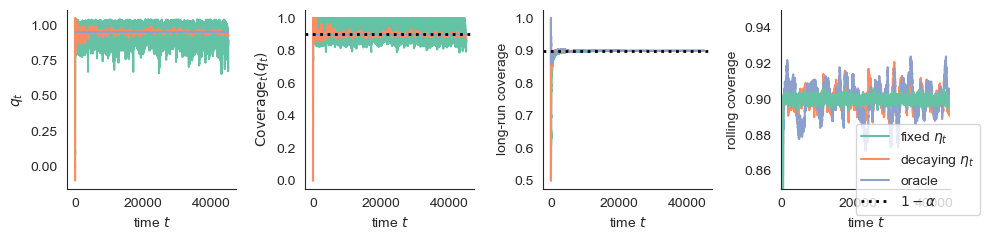

In [4]:
# Plot quantile and coverage
sns.set_style("white")
sns.set_palette('Set2')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,2.5))
axs[0].plot(range(T), q_fixed, label=r'fixed $\eta$')
axs[0].plot(range(T), q_decaying, label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
axs[0].plot(range(T), q_star*np.ones_like(q_decaying), label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
#axs[0].axhline(y=q_star, linestyle='dotted', color="k", linewidth=2, label=r'$q^*$')
axs[0].set_ylabel(r'$q_t$')
axs[0].set_xlabel(r'time $t$')
axs[1].plot(range(T), time_coverage_fixed, label=r'fixed $\eta$')
axs[1].plot(range(T), time_coverage_decaying, label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
axs[1].plot(range(T), time_coverage_qstar, label=r'$q^*$ (oracle)')
axs[1].axhline(y=1-alpha, linestyle='dotted', color="k", linewidth=2, label=r'$1-\alpha$')
axs[1].set_xlabel(r'time $t$')
axs[1].set_ylabel(r'$\mathsf{Coverage}_t(q_t)$')
axs[2].plot(range(T), LRC_fixed, label=r'fixed $\eta$')
axs[2].plot(range(T), LRC_decaying, label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
axs[2].plot(range(T), LRC_qstar, label=r'$q^*$ (oracle)')
axs[2].axhline(y=1-alpha, linestyle='dotted', color="k", linewidth=2, label=r'$1-\alpha$')
axs[2].set_xlabel(r'time $t$')
axs[2].set_ylabel(f"long-run coverage")
axs[3].plot(range(T), rolling_coverage_fixed, label=r'fixed $\eta_t$', zorder=5)
axs[3].plot(range(T), rolling_coverage_decaying, label=r'decaying $\eta_t$')
axs[3].plot(range(T), rolling_coverage_oracle, label=r'oracle')
axs[3].axhline(y=1-alpha, linestyle='dotted', color="k", linewidth=2, label=r'$1-\alpha$')
axs[3].set_xlabel(r'time $t$')
axs[3].set_ylabel("rolling coverage")
axs[3].set_xlim([W, T-W])
axs[3].set_ylim([0.85, 0.95])
axs[3].set_xticks([0,20000,40000])
axs[3].set_xticklabels([0,20000,40000])
axs[3].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axs[3].legend(loc='upper left', bbox_to_anchor=(0.4,0.4))

sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./results/', exist_ok=True)
plt.savefig('./results/imagenet-shuffled.pdf')